# Competition 2 | 3 Musketeers
#### BA545 | Spring 2019 
#### Kevin Hickey | Martin Browne | Stuart Weinstein

## Analytical Question & Goal:
What is the liklihood that a credit card client will default and ultimately force the closure of their account?  We were tasked with predictiing the liklihood of this worst case outcome for each Id in the test set.  To do this we must predict the binary value of the default variable.

![](Martin/CRISPDM.png)



## Business Understanding:
Default account closures for credit card client's result in a loss for the bank both from the write-off of the outstanding balance on the customer's statement which is a cost on the issuer's balance sheet and the loss of a customer which negatively impacts the customer's credit rating and their ability to obtain any credit or loans for the next seven years.  Essentially it's a lose-lose scenario.  

Too many default account closures also result in a poor rating for the bank (issuer) to the processor (ie. MasterCard, Visa, etc) which ultimately impacts the terms for the bank with the processor on fees and other costs.  It's a major concern for all parties involved.

So it's imperative that only truly credit worthy clients (those who will pay back their obligations) are selected as customers or, more importantly, it's crucial to flag potential client's who have a strong liklihood to default prior to an actual default and to mitigate the risk of a default account closure as early as possible.

#### Source Data
The data we are given is is also found in the UCI Machine Learning Repository. It is information of customer payment history from a Taiwan company seeking to accurately predict the probability of customer defualt. The dataset comprises of customer demographics, such as age, education, gender, etc., as well as payment amounts and payment history
for the company on a 6 period basis. Here are the components of the data that was given to us:
 
    - Credit Limit
    - Gender 
    - Level of Education 
    - Marital Status 
    - Age 
    - 6 Scored Repayment Status going back 9 months based on the delays for 6 sequential statement periods 
    - Billing Statements for 6 sequential statement periods
    - Statement Amount for 6 sequential statement periods 
    
Here are the names of the fields from the data source from the source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

- default payment (Yes = 1, No = 0), as the response variable. 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 

We decided to rename some of the features to more intuitive names; X5 has very little meaning and his difficult to remember what it corresponds to. Here are the new names of features corresponding to their original feature names and a short description of each. 

![](Data_Dictionary_picture.JPG)


##### Initial evaluation of the data and hypothesis:
The Credit Limit seemed likely to be a key feature followed by the Repayment Status scores, Billing Statements, and Statement Amount; but a better understanding of the features that lead to high and low Credit Limits, delayed repayment, increasing billing statements and the statement amount needed to be gained.  Initially, we hoped to gain insights based on the data provided and create an analytic process based on the results with some very basic models, literally a series of charts to visualize the features.  Ultimately, we were seeking a reliable, repeatable method to predict  






## Data Understanding 

We will begin by looking from a high level what some of our features look like. This includes the target variable as well, ad will conclude with looking at the correlation values for all variables. 


In [19]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import scipy.stats
from Modules import *
sns.set()
%matplotlib inline

In [20]:
def read_data(path):
    df = pd.read_excel(path, header=0)

    df.columns = df.iloc[0,:]

    df.rename(index=str, columns={"default payment next month": "Y"}, inplace=True)

    y = df.Y

    df.drop('ID', inplace=True, axis = 0)
    y.drop('ID', inplace=True, axis = 0)
    #df.drop(columns = 'Y', inplace = True)
    df = df.astype('int32')
    y = y.astype('int32')
    
    #replace 'PAY_0' with 'PAY_1' in order to allign with 'BILL_AMT1' and 'PAY_AMT1'
    df.rename(index=str, columns = {'PAY_0': 'PAY_1'}, inplace=True)

    return df,  y

df, y= read_data('default_of_credit_card_clients.xls')


In [21]:
df.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [12]:
#Initial numeric columns to look at
df[['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

ID,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


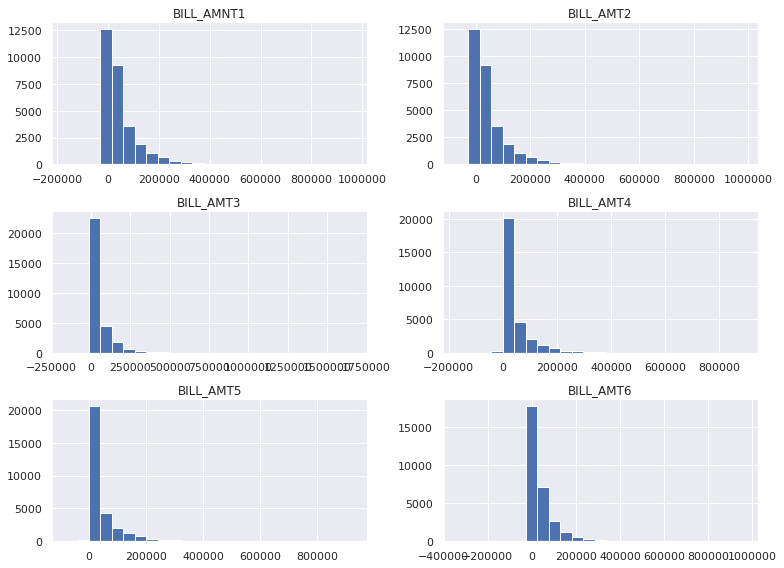

In [13]:
#create bill_amnts group
fig = plt.figure(figsize = (11,8))
bill_amts = df.loc[:, 'BILL_AMT1':'BILL_AMT6']


plt.subplot(3,2,1)
ax1 = bill_amts['BILL_AMT1'].hist(bins=25)
ax1.set_title('BILL_AMNT1')

plt.subplot(3,2,2)
ax2 = bill_amts['BILL_AMT2'].hist(bins=25)
ax2.set_title('BILL_AMT2')

plt.subplot(3,2,3)
ax3 = bill_amts['BILL_AMT3'].hist(bins=25)
ax3.set_title('BILL_AMT3')

plt.subplot(3,2,4)
ax4 = bill_amts['BILL_AMT4'].hist(bins=25)
ax4.set_title('BILL_AMT4')

plt.subplot(3,2,5)
ax5 = bill_amts['BILL_AMT5'].hist(bins=25)
ax5.set_title('BILL_AMT5')

plt.subplot(3,2,6)
ax6 = bill_amts['BILL_AMT6'].hist(bins=25)
ax6.set_title('BILL_AMT6')

plt.tight_layout()

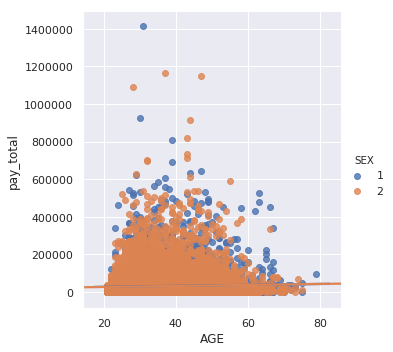

In [25]:

#Male & Female default ratio on the basis of pay_total & age -  inspiration for some of these charts was taken from kaggle
df['pay_total'] = (df.PAY_AMT1 + df.PAY_AMT2 + df.PAY_AMT3 + df.PAY_AMT4 + df.PAY_AMT5 + df.PAY_AMT6)
df.pay_total = df.pay_total.where(df.pay_total < 1500000)
sns.lmplot(x="AGE", y=("pay_total"), data = df, hue = "SEX")

/opt/tljh/user/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


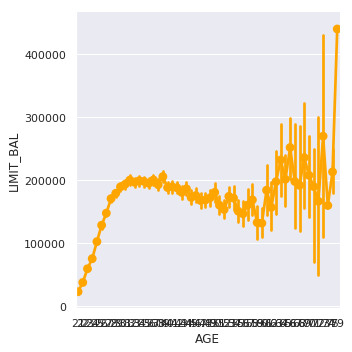

In [26]:
sns.factorplot(x='AGE',y='LIMIT_BAL',data=df, color ="orange",title  = "Limit Balance by Age")

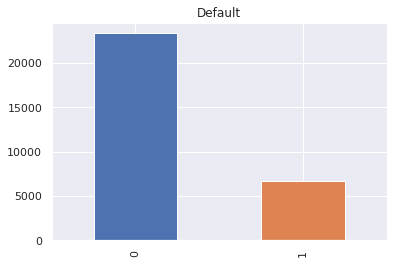

In [22]:
y.value_counts().plot(kind = 'bar', title  = "Default")

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

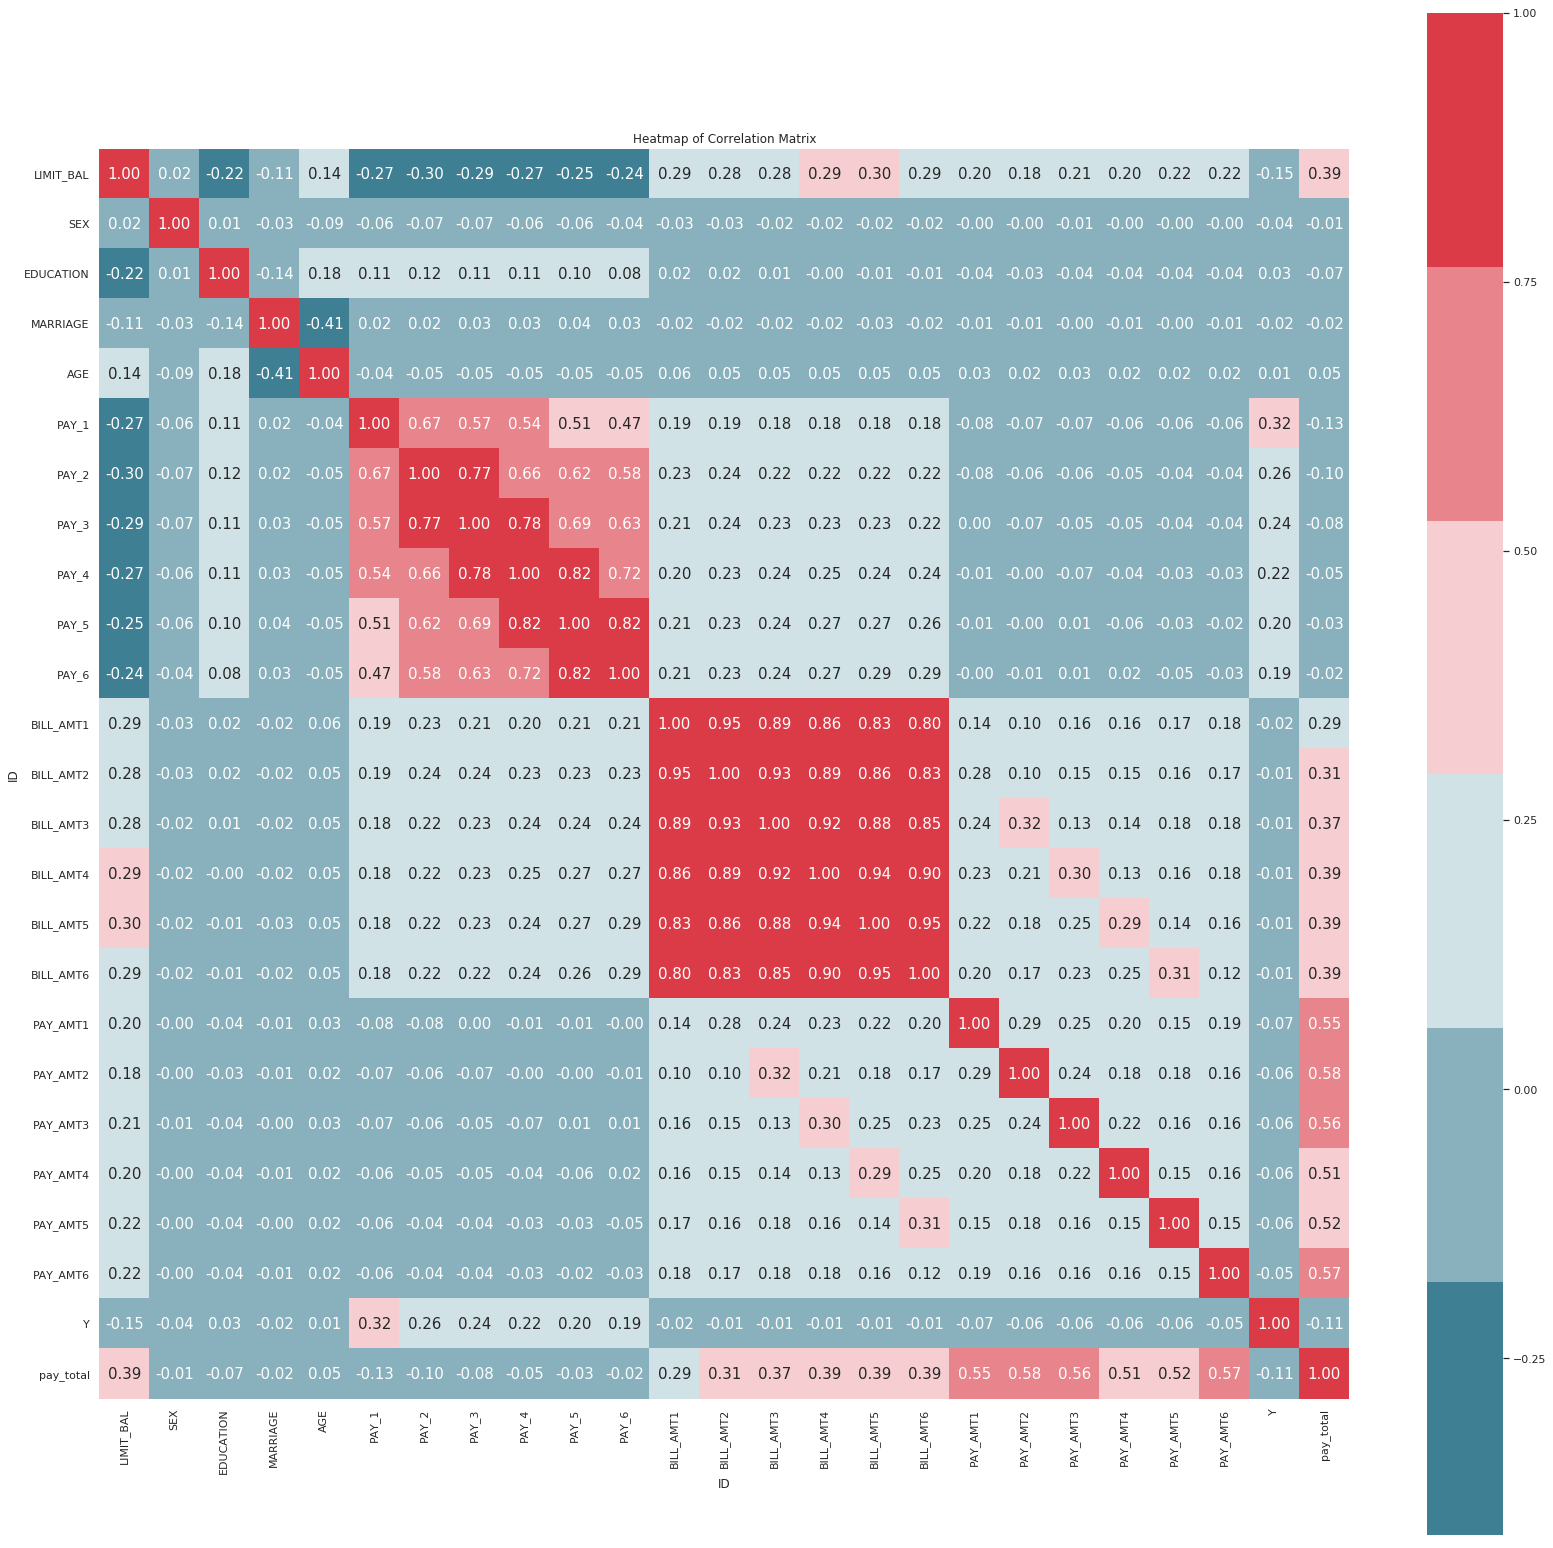

In [17]:
corr=df.corr()
corr = (corr)
plt.figure(figsize=(28,28))
sns.heatmap(corr, cbar = True, square = True,  cmap = sns.diverging_palette(220, 10), annot=True, fmt= '.2f',annot_kws={'size': 15},
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values).set_title('Heatmap of Correlation Matrix')


## Data Preparation 

The first thing we did was to read in the data into a suitable format. This involved reading the Excel file and naming the columns into something more intuitive than the original column names.

There are no missing data points, so **imputation is not necessary**.

Next, after noting the discrepencies in the values for the classes for  'EDUCATION', 'SEX', and 'MARRIAGE' features, we dediced to rename and replace many of these values. For instance, the 'EDUCATION' feature had a majority of  "Graduate School" and "University" class, and a very limited amount of the other classes, so we dicided to keep the 2 former classes and bin the latter classes into a category of "Other". A similar process was done for the other two features

We also noted, undefined values in some of the features. -2 and "0" appear frequently in the "pay_" features. We tested a few strategies to see if adjusting this values effected our inital results. We eventually decided to bin together these two values into a new logical feature, which is used in the final dataset, as shown later in the presentation. 




## Sequential Data Feature Engineering

In the following code, we will engineer some new features based on the sequential information given in the PAY_AMT and BILL_AMT columns.

First, we calculate the amount of outstanding balance remaining for a client after he/she has payed a bill. This is simply the difference of a bill amount for a time period and the amount payed for that time period.

In [3]:
# created new feature OUTSTANDING_BAL for each period

df["OUTSTANDING_BAL1"] = (df.BILL_AMT1 - df.PAY_AMT1)
df["OUTSTANDING_BAL2"] = (df.BILL_AMT2 - df.PAY_AMT2)
df["OUTSTANDING_BAL3"] = (df.BILL_AMT3 - df.PAY_AMT3)
df["OUTSTANDING_BAL4"] = (df.BILL_AMT4 - df.PAY_AMT4)
df["OUTSTANDING_BAL5"] = (df.BILL_AMT5 - df.PAY_AMT5)
df["OUTSTANDING_BAL6"] = (df.BILL_AMT6 - df.PAY_AMT6)



Next, we'll create new logical variables; these will indicate whether the outstanding balance value has increased (1) or not (0) from the previous period.

In [4]:
#create logical variable: 
#if the outstanding balance for period t-1 is less than period t: 0
#if the outstanding balance for perriod t-1 is more than period t: 1

lst1 = ['OUTSTANDING_BAL1','OUTSTANDING_BAL2', 'OUTSTANDING_BAL3', 'OUTSTANDING_BAL4','OUTSTANDING_BAL5']
lst2 = ['OUTSTANDING_BAL2','OUTSTANDING_BAL3', 'OUTSTANDING_BAL4', 'OUTSTANDING_BAL5','OUTSTANDING_BAL6',]
for idx, (column1, column2) in enumerate(zip(lst1, lst2)):
    idx += 1
    df[f"OUSTANDING_BAL_{idx}_INDICATOR"] = np.where(df[column1] > df[column2], 1, 0)


#possible idea: do a ratio of how much your outstanding balance grew from t-1 to t ((new-old)/old)

Now, we'll do a similar process for the following: we'll calculate a ratio of how much a client's outstanding balance compares to his or her LIMIT_BAL of the account. Then we'll again create a logical variable indicating whether the balance of the current time period has increased (1) or not (0) from the previous time period.

In [5]:
#created new column %_LIMIT_BAL for each month
#oustanding balance of period t divided by LIMIT_BAL 
#how close is a client reaching that LIMIT_BAL limit?

df["PERCENT_OF_LIMIT_BAL1"] = (df.OUTSTANDING_BAL1 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL2"] = (df.OUTSTANDING_BAL2 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL3"] = (df.OUTSTANDING_BAL3 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL4"] = (df.OUTSTANDING_BAL4 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL5"] = (df.OUTSTANDING_BAL5 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL6"] = (df.OUTSTANDING_BAL6 / df.LIMIT_BAL)



In [6]:
#if the outstanding balance for period t-1 is less than period t: 0
#if the outstanding balance for perriod t-1 is more than period t: 1 * 


lst1 = ['PERCENT_OF_LIMIT_BAL1','PERCENT_OF_LIMIT_BAL2', 
        'PERCENT_OF_LIMIT_BAL3','PERCENT_OF_LIMIT_BAL4', 
        'PERCENT_OF_LIMIT_BAL5']

lst2 = ['PERCENT_OF_LIMIT_BAL2', 'PERCENT_OF_LIMIT_BAL3',
       'PERCENT_OF_LIMIT_BAL4', 'PERCENT_OF_LIMIT_BAL5',
       'PERCENT_OF_LIMIT_BAL6']

for idx, (col1, col2) in enumerate(zip(lst1, lst2)):
    idx += 1
    df[f"PERCENT_OF_LIMIT_{idx}_INDICATOR"] = np.where(df[col1] < df[col2], (1 * ((6-idx)/5)), 0)



### what ratio of the bill are they paying?
### similar to oustanding balance, might have to choose

Here, we will calculate what percentage of the bill the client is paying off each time period. Then, we'll create a logical variable indicating whether the ratio of the current time period is increaseing (1) or not (0) compared to the previous time period.

In [7]:
#describe the percentage of the bill that clients are paying
#have to set if a bill amt is 0, will be the same as the previous time periods value
#therefore, have to initialize the the time period, t = 6 values first 

lst1 = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4','BILL_AMT5', 'BILL_AMT6']
lst2 = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for idx, (col1, col2) in enumerate(zip(lst1, lst2)):
    idx +=1
    df[f"PAY_RATIO_{idx}"] = np.where(df[col1] != 0, df[col2]/df[col1], 1)


In [8]:
#create the indicator
#if the ratio is increasing across the months we will give them a value of (6-(time period))/5.
#for instace, PAY_RATIO_2_INDICATOR has a value of .8 when the condition holds

lst1 = ['PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4','PAY_RATIO_5']
lst2 = ['PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4','PAY_RATIO_5', 'PAY_RATIO_6']
for idx, (col1, col2) in enumerate(zip(lst1, lst2)):
    idx +=1
    df[f"PAY_RATIO_{idx}_INDICATOR"] = np.where(df[col1] < df[col2], (1 * ((6-idx)/5)), 0)

In [9]:
df.head().T

,1,2,3,4,5
LIMIT_BAL,20000.000000,120000.000000,90000.000000,50000.000000,50000.000000
AGE,24.000000,26.000000,34.000000,37.000000,57.000000
PAY_1,2.000000,-1.000000,0.000000,0.000000,-1.000000
PAY_2,2.000000,2.000000,0.000000,0.000000,0.000000
PAY_3,-1.000000,0.000000,0.000000,0.000000,-1.000000
PAY_4,-1.000000,0.000000,0.000000,0.000000,0.000000
PAY_5,-2.000000,0.000000,0.000000,0.000000,0.000000
PAY_6,-2.000000,2.000000,0.000000,0.000000,0.000000
BILL_AMT1,3913.000000,2682.000000,29239.000000,46990.000000,8617.000000
BILL_AMT2,3102.000000,1725.000000,14027.000000,48233.000000,5670.000000


![](Complete_data_dictionary.JPG)

*link to complete data dictionary*:  **[Data Dictionary](Complete_data_dictionary.JPG)** 

##### Datasets:

Individually we worked on different versions of the dataset. Martin took the most basic dataset that was supplied:

Stuart and Kevin worked on datasets with new feature engineering that we as a group developed including ratio analysis of payments,limits and trends As a group, each participant has run various models on a specific dataset
    - Stuart: Full dataset with all of the features
    - Martin: Niave dataset with the initial features
    - Kevin: limited dataset thought to have the most potential based on f1 training
    


## Modeling:

We began by testing a number of different models on the baseline data set with little preprocessing. The data was oversampled using the SMOTE technique. The results of the models were: 

| MODEL | F1 (cross-val score) | AUC |
| --- | --- | --- |
| Logistic Regression (Martin) | .409 | .61 |
| SVC (Martin) | .404 | .61 |
| Kneighbours (Stuart) | .344(.266) | .56 |
| Random Forest Classifier (Martin) | .511(.471) | .68 |
| Light gbm (Martin) | .495(.471) | .67 |
| Cat boost classifier (Martin) | .514(.477) | .68 |
| Decision tree (Stuart) | .399(.396) | .62 |
| GaussianNB (Kevin) | .366(387) | .54 |
| XGBoost3 Classifier (Kevin) | .537 | .710 |
| LogisticRegression (Kevin) |.529 | .705 |
   |   |   
   
The best performing model was the XGBoost model created by Kevin with his curated data. Here, we'll briefly show how he created his data. He eliminated some features, and created new bins for the 'PAY_N' features to be into four distinct bins: on time, one month late, more than one month late, and other, with other being the undefined values of -2 and 0, as discussed previously on the Data Understanding section. 

In [6]:
#trying binning the PAY_ columns to something more specific
#any value that is late more than 2 months will be "more_than 2_months"
#any value that is one month late will be "1_month_late"
#any value on time will be "on_time"
#any 0, or -2 value, which are not defined by dictionary, will be "other"
values = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
columns = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for col in columns:
  df[col] = df[col].replace([values[0], values[2]], 'Other')
  df[col] = df[col].replace(values[1], "on_time")
  df[col] = df[col].replace(values[3], "one_month_late")
  df[col] = df[col].replace(values[4:], "more_than_two_month_late")




In [18]:
df = pd.get_dummies(df)
df.head(2)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,pay_total
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,689,0,0,0,0,1,689.0
2,120000,2,2,2,26,-1,2,0,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,5000.0


## Data Preparation & Modeling 2

Here is the notebook that holds the code used to create the final best performing model.  [Final_model_process.ipynb](Kevin/Final_model_process.ipynb) We will go through this notebook now. 


## Evaluation:

After developing our best performing model, we decided to utilize a range of feautre selection methods to try and improve our results. The processes and methods to do so are described in [link](Kevin/Feature_selection.ipynb) notebook. We will go through that notebook now. 

## Conclusion:


To conclude, our best results are reproduced below. Our best model was in fact an xgboost model with they hyperparameters tuned to the values as in 'xgboost3'. By implementing various library's we were able to see that the features that contribute most to prediction of default is a client's delayment of payments for more than one month. For the most recent time periods, having a delayment of more than 1 month is the strongest indicator of the potential for defaulting on payments. Therefore, we suggest that managers carefully track and tag any potential delay in payment of a client, for spotting these potentially harmful clients early can help the company act in advance and avoid the consequences of not catching a harmful client too late.  

In [48]:
Train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 2019)

target = 'Y'


loaded_model = joblib.load('Models/xgboost3.dat')

loaded_model.fit(Train_data[predictors_shap], Train_data[target])

y_pred_shap = loaded_model.predict(test_data[predictors_shap])




In [51]:
print(f"Overall Accuracy: {metrics.accuracy_score(test_data[target], y_pred_shap)}")
print()
print(f"Overall AUC: {metrics.roc_auc_score(test_data[target], y_pred_shap)}")
print()
print(f"Overall F1: {metrics.f1_score(test_data[target], y_pred_shap)}")
print()
print("Classification Report: ")
print(metrics.classification_report(test_data[target], y_pred_shap))

Overall Accuracy: 0.7851666666666667

Overall AUC: 0.7134375154298128

Overall F1: 0.5404634581105169

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4710
           1       0.50      0.59      0.54      1290

   micro avg       0.79      0.79      0.79      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000

